# Efficient Solvers for Large Problems
Until now, we have mostly used one-dimensional geometries with a limited number of nodes and elements. The resulting linear systems have a relatively modest size ($N \times N$, with $N$ in the hundreds or thousands). These can be easily solved using the backslash operator `\` without paying much attention to the memory usage and computation time.

However, when moving to geometries with more elements (such as two-dimensional geometries), the solving time of the linear system can become quite significant. In this notebook, we will investigate the performance of various linear solvers for linear systems of different sizes. This can then be used as a guideline for choosing a linear solver for high performance.

# Linear Solvers
In this section we briefly introduce the different methods available for solving linear systems. In particular, we will focus on _sparse_ linear systems, which are representative of the FEM problems we want to solve efficiently. For easy benchmarking, we will use the interface provided by `LinearSolve.jl`.

## Factorization

 - LU factorization
 - QR factorization
 - SVD factorization

## Iterative methods
Iterative methods are recommended in any of the following situations:
 - the problem is sufficiently large that a factorization is not feasible or would be slow,
 - an effective preconditioner is known in cases where the problem has unfavorable spectral structure,
 - the operator can be represented efficiently as a sparse matrix,
 - the operator is fast, i.e., can be applied with better complexity than if it were materialized as a matrix. Certain fast operators would materialize as dense matrices.

### Krylov

 - Conjugate gradient: For symmetric positive-definite matrices
 - GMRES: For nonsymmetric matrices
 - Bi-CGStab (Stabilized bi-conjugate gradient): For nonsymmetric matrices

### Algebraic Multigrid

# Benchmarking

In [1]:
using LinearAlgebra, SparseArrays
using LinearSolve
using Preconditioners, AlgebraicMultigrid, Krylov, IncompleteLU

using BenchmarkTools
using Plots

In [2]:
function generate_mesh(Nel)
    x = 0:1/Nel:1;

    # Collect points (left and right nodes for each element) and edges (connectivity: indices of left and right nodes)
    N = length(x);
    points = collect( [x[i], x[i+1]] for i in 1:N-1) 
    edges  = collect( [i, i+1] for i in 1:N-1); 

    elem_ids = 1:length(edges)
    e_group = ones(size(edges));
    
    #..Set the source function 
    fsource(group_id) = 1;
    fsource_elem = map(fsource, e_group);
    
    return x, edges, N, elem_ids, fsource_elem
end

# Compute the length h of an element, given its ID and the global list of elements and points
function compute_element_area(elem_id, e, p)
    area_id = p[e[elem_id][2]] - p[e[elem_id][1]]
    return area_id
end

function assemble_matrices(elem_ids, elems, x, N)
    # Calculate element length h
    elem_area = map(elem_id -> compute_element_area(elem_id, elems, x), elem_ids);
    
    # Generate index vectors
    I = reduce(vcat, view.(elems, Ref([1, 2, 1, 2])))
    J = reduce(vcat, view.(elems, Ref([1, 1, 2, 2])))
    
    # Generate matrix contributions
    Atempl = [1, -1, -1, 1];
    V = reduce(vcat, map(h -> Atempl / h, elem_area));
    
    A = sparse(I, J, V, N, N);
       
    return A
end

assemble_matrices (generic function with 1 method)

In [3]:
N_ = [128, 512, 1024, 2048, 8192, 32768];
N_ = N_ .- 1;

probs = Vector{LinearProblem}();
for (i, Nel) = enumerate(N_)
    x, edges, N, elem_ids, _ = generate_mesh(Nel)
    A = assemble_matrices(elem_ids, edges, x, N);
    f = rand(N);
    
    A[1,:]   = zeros(N);  A[1,1]     = 1;      f[1]   = 0;
    A[end,:] = zeros(N);  A[end,end] = 1;      f[end] = 0;
    
    A[2,1] = 0; A[end-1,end] = 0;
   
    prob = LinearProblem(A, f);
    push!(probs, prob);
end

In [4]:
BenchmarkTools.DEFAULT_PARAMETERS.seconds = 1

1

## Reference

In [73]:
ref_time = zeros(1, length(probs))
ref_mem  = zeros(1, length(probs))

for (j, prob) in enumerate(probs)
    A = prob.A;
    f = prob.b;
    bm = @benchmark begin
        $A \ $f
    end

    ref_time[j] = mean(bm).time * 1e-6;
    ref_mem[j]  = bm.memory / 1024;
end

In [5]:
ref_time = [0.0397462  0.125646  0.231863  0.473033  1.89972  7.84068];
ref_mem  = [54.1406  210.406  418.406  834.328  3330.25  13314.2];

## Factorization

In [77]:
algs = (
    LUFactorization(),
    UMFPACKFactorization(),
    KLUFactorization(),
)
time = zeros(length(algs), length(probs))
mem  = zeros(length(algs), length(probs))

for (i, alg) in enumerate(algs)
    for (j, prob) in enumerate(probs)
        bm = @benchmark begin
            LinearSolve.solve($prob, $alg).u
        end

        time[i, j] = mean(bm).time * 1e-6;
        mem[i, j]  = bm.memory / 1024;
    end
end

In [6]:
time = [0.104581   0.349976  0.660243  1.39458   6.9741   28.7384
 0.103413   0.347776  0.674643  1.38543   7.19113  28.8599
 0.0506432  0.149658  0.283264  0.542075  2.18568  10.2828];
mem = [161.711   593.586  1168.48   2318.71  9220.88  36830.5
 167.695   617.633  1216.37   2414.52  9604.77  38366.4
  86.8125  309.359   605.055  1196.91  4748.73  18956.8];
alg_labels = ["LU Factorization" "UMFPACK Factorization" "KLU Factorization"];

1×3 Matrix{String}:
 "LU Factorization"  "UMFPACK Factorization"  "KLU Factorization"

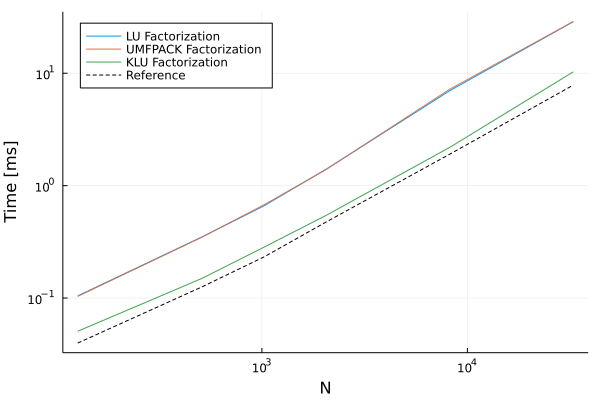

In [7]:
plot(N_, time', xaxis = :log, yaxis = :log, xlabel = "N", ylabel = "Time [ms]", legend = :topleft, labels = alg_labels)
plot!(N_, ref_time', xaxis = :log, yaxis = :log, color = :black, linestyle = :dash, label = "Reference")

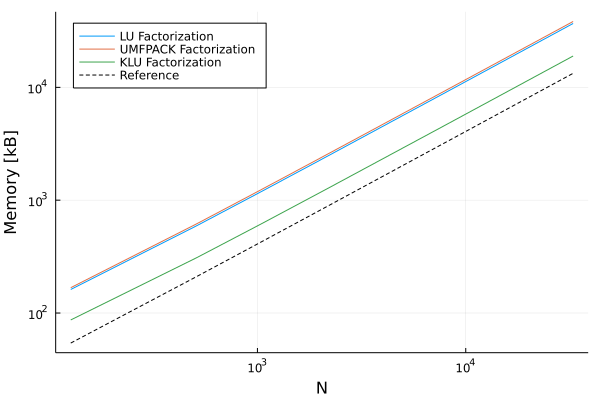

In [8]:
plot(N_, mem', xaxis = :log, yaxis = :log, xlabel = "N", ylabel = "Memory [kB]", legend = :topleft, labels = alg_labels)
plot!(N_, ref_mem', xaxis = :log, yaxis = :log, color = :black, linestyle = :dash, label = "Reference")

## Iterative Methods - Conjugate Gradient

In [83]:
algs = (
    IterativeSolversJL_CG(),
    IterativeSolversJL_CG(),
    IterativeSolversJL_CG(),
    KrylovJL_CG(),
    KrylovJL_CG(),
    KrylovJL_CG(),
)
preconds = (
    nothing,
    A -> DiagonalPreconditioner(A),
    A -> CholeskyPreconditioner(A, 2),
    nothing,
    A -> DiagonalPreconditioner(A),
    A -> CholeskyPreconditioner(A, 2)
)

time = zeros(length(algs), length(probs))
mem  = zeros(length(algs), length(probs))

for (i, alg) in enumerate(algs)
    for (j, prob) in enumerate(probs)
        p = preconds[i];
        if p == nothing
            bm = @benchmark begin
                LinearSolve.solve($prob, $alg).u
            end
        else
            pre = p(prob.A);
            bm = @benchmark begin
                LinearSolve.solve($prob, $alg, Pl = $pre).u
            end
        end

        time[i, j] = mean(bm).time * 1e-6;
        mem[i, j]  = bm.memory / 1024;
    end
end

In [9]:
time = [ 0.0715641   1.04942     4.0613      16.9367      299.872      7037.88
 0.494033    8.57559    35.2255     146.127      2495.86      66195.8
 0.00657818  0.021952    0.0448338    0.0854898     0.329081      2.21831
 0.0770495   1.06875     4.18092     17.1127      297.708     12928.7
 0.536007    8.85076    36.5051     158.071      2498.13      67658.9
 0.00911116  0.0248959   0.0466537    0.0913092     0.310828      2.31803];
mem = [16.9062  62.5625  122.406  242.328   961.703  3841.7
 16.9062  62.5625  122.406  242.328   961.703  3841.7
 16.9062  62.5781  122.422  242.344   961.719  3841.72
 19.6875  71.4688  139.312  275.234  1090.45   4354.45
 20.75    75.5938  147.438  291.359  1154.5    4610.5
 20.75    75.625   147.469  291.391  1154.53   4610.53];
alg_labels = ["IterativeSolvers" "IterativeSolvers + Diagonal" "IterativeSolvers + Cholesky" "Krylov" "Krylov + Diagonal" "Krylov + Cholesky"];

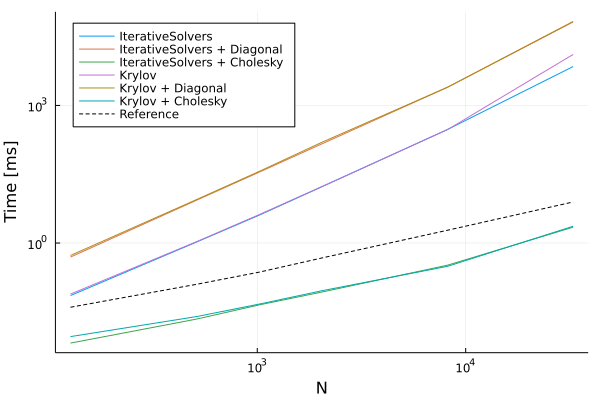

In [10]:
plot(N_, time', xaxis = :log, yaxis = :log, xlabel = "N", ylabel = "Time [ms]", legend = :topleft, labels = alg_labels)
plot!(N_, ref_time', xaxis = :log, yaxis = :log, color = :black, linestyle = :dash, label = "Reference")

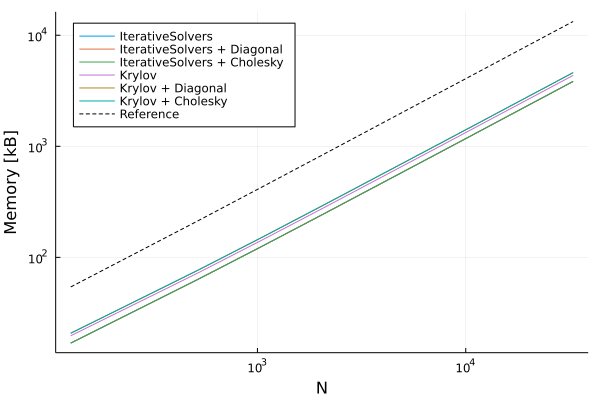

In [11]:
plot(N_, mem', xaxis = :log, yaxis = :log, xlabel = "N", ylabel = "Memory [kB]", legend = :topleft, labels = alg_labels)
plot!(N_, ref_mem', xaxis = :log, yaxis = :log, color = :black, linestyle = :dash, label = "Reference")

## Iterative Methods - GMRES

In [12]:
algs = (
    #KrylovJL_GMRES(),
    #KrylovJL_GMRES(),
    KrylovJL_GMRES(),
    KrylovJL_GMRES(),
    KrylovJL_GMRES(),
)
preconds = (
    #nothing,
    #A -> DiagonalPreconditioner(A),
    A -> AMGPreconditioner{RugeStuben}(A),
    A -> AMGPreconditioner{SmoothedAggregation}(A),
    A -> ilu(A, τ = 0.1)
)

time = zeros(length(algs), length(probs))
mem  = zeros(length(algs), length(probs))

for (i, alg) in enumerate(algs)
    for (j, prob) in enumerate(probs)
        p = preconds[i];
        if p == nothing
            bm = @benchmark begin
                LinearSolve.solve($prob, $alg).u
            end
        else
            pre = p(prob.A);
            bm = @benchmark begin
                LinearSolve.solve($prob, $alg, Pl = $pre).u
            end
        end

        time[i, j] = mean(bm).time * 1e-6;
        mem[i, j]  = bm.memory / 1024;
    end
end

In [15]:
time = [0.0904597  0.368018   0.766865  1.32533   5.55389   22.8267
 0.080828   0.319073   0.601866  1.2942    4.15348   27.9954
 0.0255927  0.0806704  0.13883   0.198269  0.879678   5.46906];
mem  = [64.5625  230.281  446.125  878.047  3466.38  13834.4
 64.5625  230.281  446.125  878.047  3466.38  13834.4
 64.5625  230.281  446.125  878.047  3466.38  13834.4];
#alg_labels = ["Krylov" "Krylov + Diagonal" "Krylov + AMG (RS)" "Krylov + AMG (SA)" "Krylov + ILU (0.1)"]
alg_labels = ["Krylov + AMG (RS)" "Krylov + AMG (SA)" "Krylov + ILU (0.1)"];

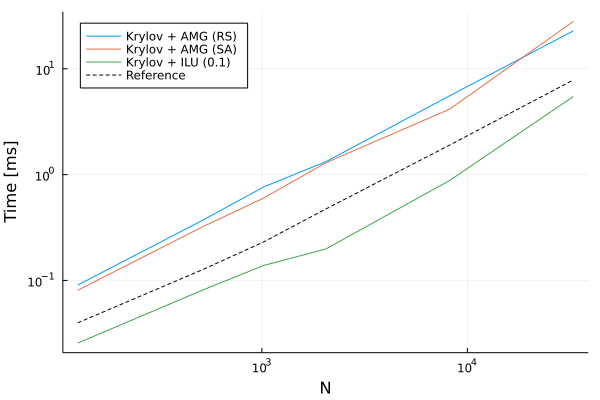

In [16]:
plot(N_, time', xaxis = :log, yaxis = :log, xlabel = "N", ylabel = "Time [ms]", legend = :topleft, labels = alg_labels)
plot!(N_, ref_time', xaxis = :log, yaxis = :log, color = :black, linestyle = :dash, label = "Reference")

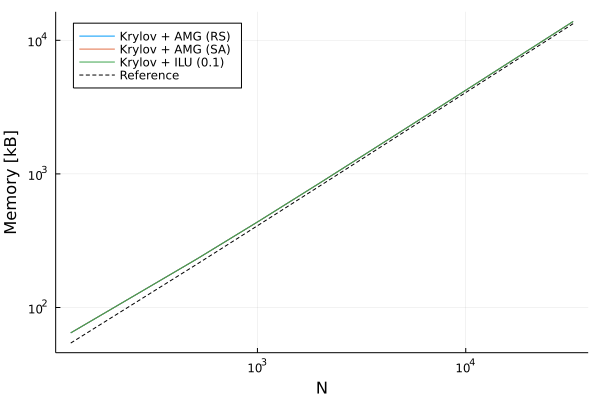

In [17]:
plot(N_, mem', xaxis = :log, yaxis = :log, xlabel = "N", ylabel = "Memory [kB]", legend = :topleft, labels = alg_labels)
plot!(N_, ref_mem', xaxis = :log, yaxis = :log, color = :black, linestyle = :dash, label = "Reference")

# Benchmarking (Complex Matrices)